# Edge Detection

It is advisable that you'll create an helper function that will display images for you during this exercise

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import signal
%matplotlib inline
import scipy
from scipy import ndimage

In [2]:
def plot_images(image_list, title_list, subplot_shape=(1,1), axis='off', 
                fontsize=30, figsize=(4,4), cmap=['gray']):
    
    plt.figure(figsize=figsize)
    for i, im in enumerate(image_list):
        c_title = title_list[i]
        if len(cmap) > 1:
            c_cmap = cmap[i]
        else:
            c_cmap = cmap[0]
        plt.subplot(subplot_shape[0], subplot_shape[1],i+1)
        plt.imshow(im, cmap=c_cmap)
        plt.title(c_title, fontsize=fontsize)
        plt.axis(axis);

## Sobel

Read zebra.jpg image, convert it to gray scale and plot the horizontal and vertical gradients using the Sobel operator. Plot the gradient magnitude as well

**sourse link:**<br>https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html<br>https://stackoverflow.com/questions/44062292/generating-plotting-histograms-of-gradient-magnitude-orientation

(1024, 1018)


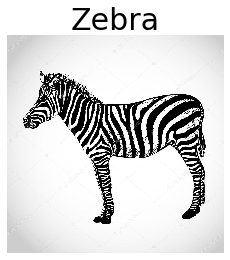

In [3]:
zebra = cv2.imread('zebra.jpg',0)
print(zebra.shape)
plot_images([zebra],['Zebra'])

In [4]:
def get_gradient(img):
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5).astype('float32')
    sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5).astype('float32')
    
    grad = np.hypot(sobelx, sobely)
    grad = grad / grad.max() * 255
    theta = np.arctan2(sobely, sobelx)
    
    return sobelx, sobely, grad, theta

**sourse link:**<br>https://stackoverflow.com/questions/59975604/how-to-inverse-a-dft-with-magnitude-with-opencv-python<br>https://stackoverflow.com/questions/38961957/cv2-phase-gives-the-angle-in-radian<br>https://www.programcreek.com/python/example/89325/cv2.Sobel

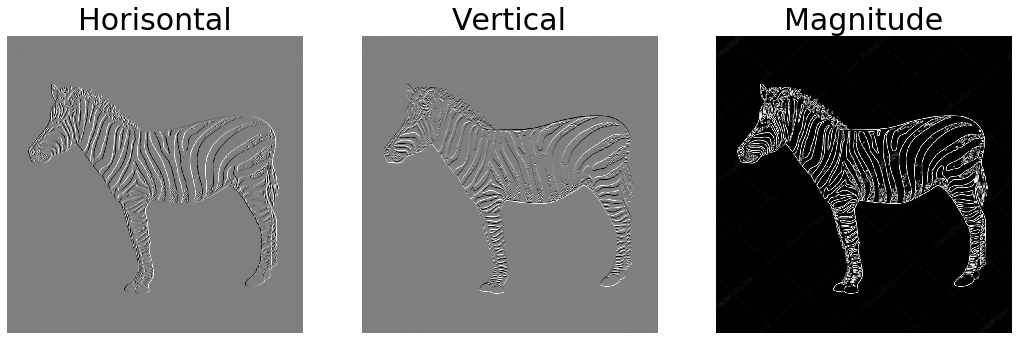

In [5]:
sobelx,sobely, magnitude ,_= get_gradient(zebra)

plot_images([sobelx,sobely,magnitude],
            ['Horisontal','Vertical', 'Magnitude'],
            subplot_shape=(1,3),
            figsize=(18,6))

## Smoothing

Read zebra.jpg image, plot in 3 different "soothness" levels using Gaussian Blur"

**sourse link:**<br>https://www.tutorialkart.com/opencv/python/opencv-python-gaussian-image-smoothing/<br>https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html

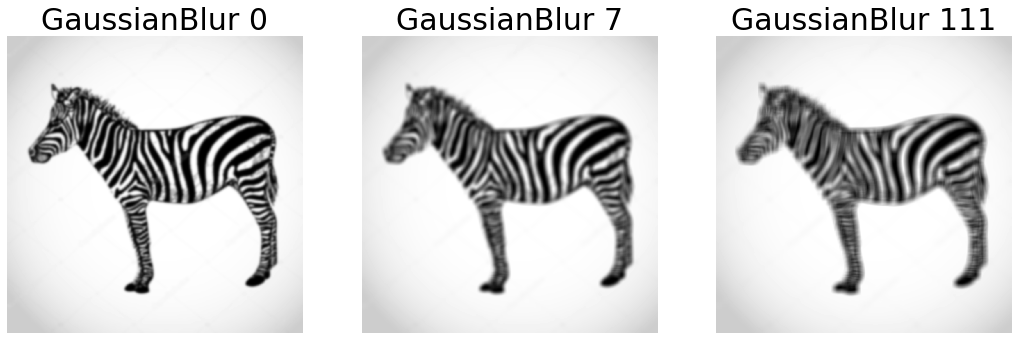

In [6]:
dsts =[]
titles = []
for sm in (0,7,111):
    dst= cv2.GaussianBlur(zebra,(23,23),sm).astype("uint8")
    dsts.append(dst)
    titles.append(f'GaussianBlur {sm}')
plot_images(dsts,titles,subplot_shape=(1,3),figsize=(18,6))

## Smoothing + Sobel
Now plot the gradient magnitude for those 3 different smoothness levels. <br>
Where is it easier to spot the animal outline? <br>
Where is it easier to spot the lines of the zebra?

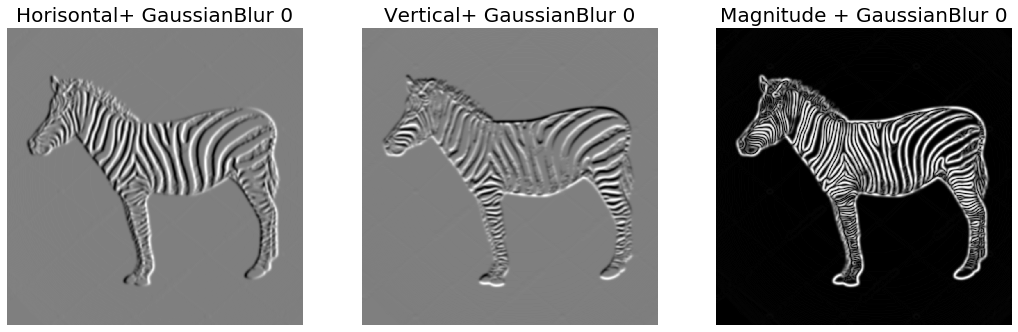

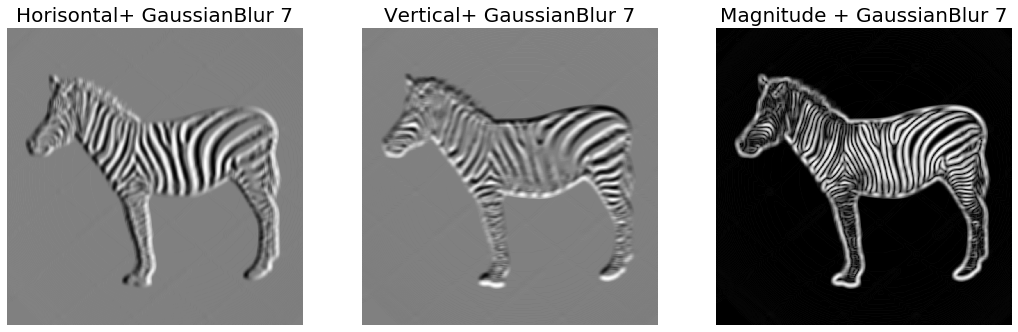

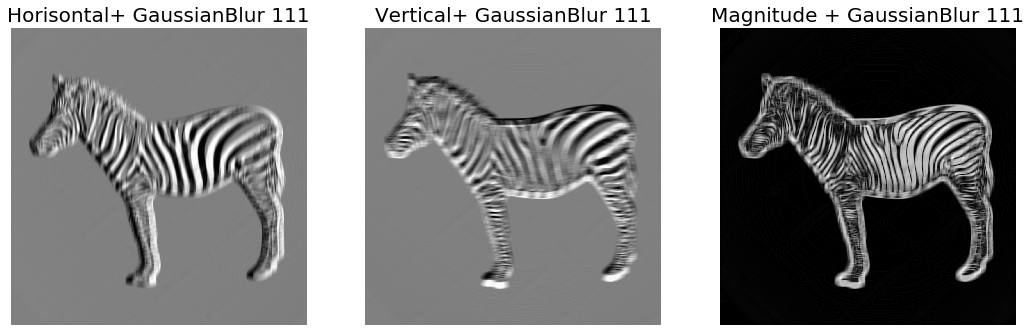

In [7]:
for sm in (0,7,111):
    dst= cv2.GaussianBlur(zebra,(23,23),sm).astype("uint8")

    sobelx_dst, sobely_dst, mag_dst,_ = get_gradient(dst)
    
    plot_images([sobelx_dst,sobely_dst,mag_dst],
                [f'Horisontal+ GaussianBlur {sm}',
                 f'Vertical+ GaussianBlur {sm}',
                f'Magnitude + GaussianBlur {sm}'],
                subplot_shape=(1,3),
                figsize=(18,6),
               fontsize=20)

As we can see, the less level of smoothness the easier to spot the lines of the zebra, the higher level of smoothness, the easier to spot animal outline

## Canny Edge Detection

In this part we will implement Canny edge detection

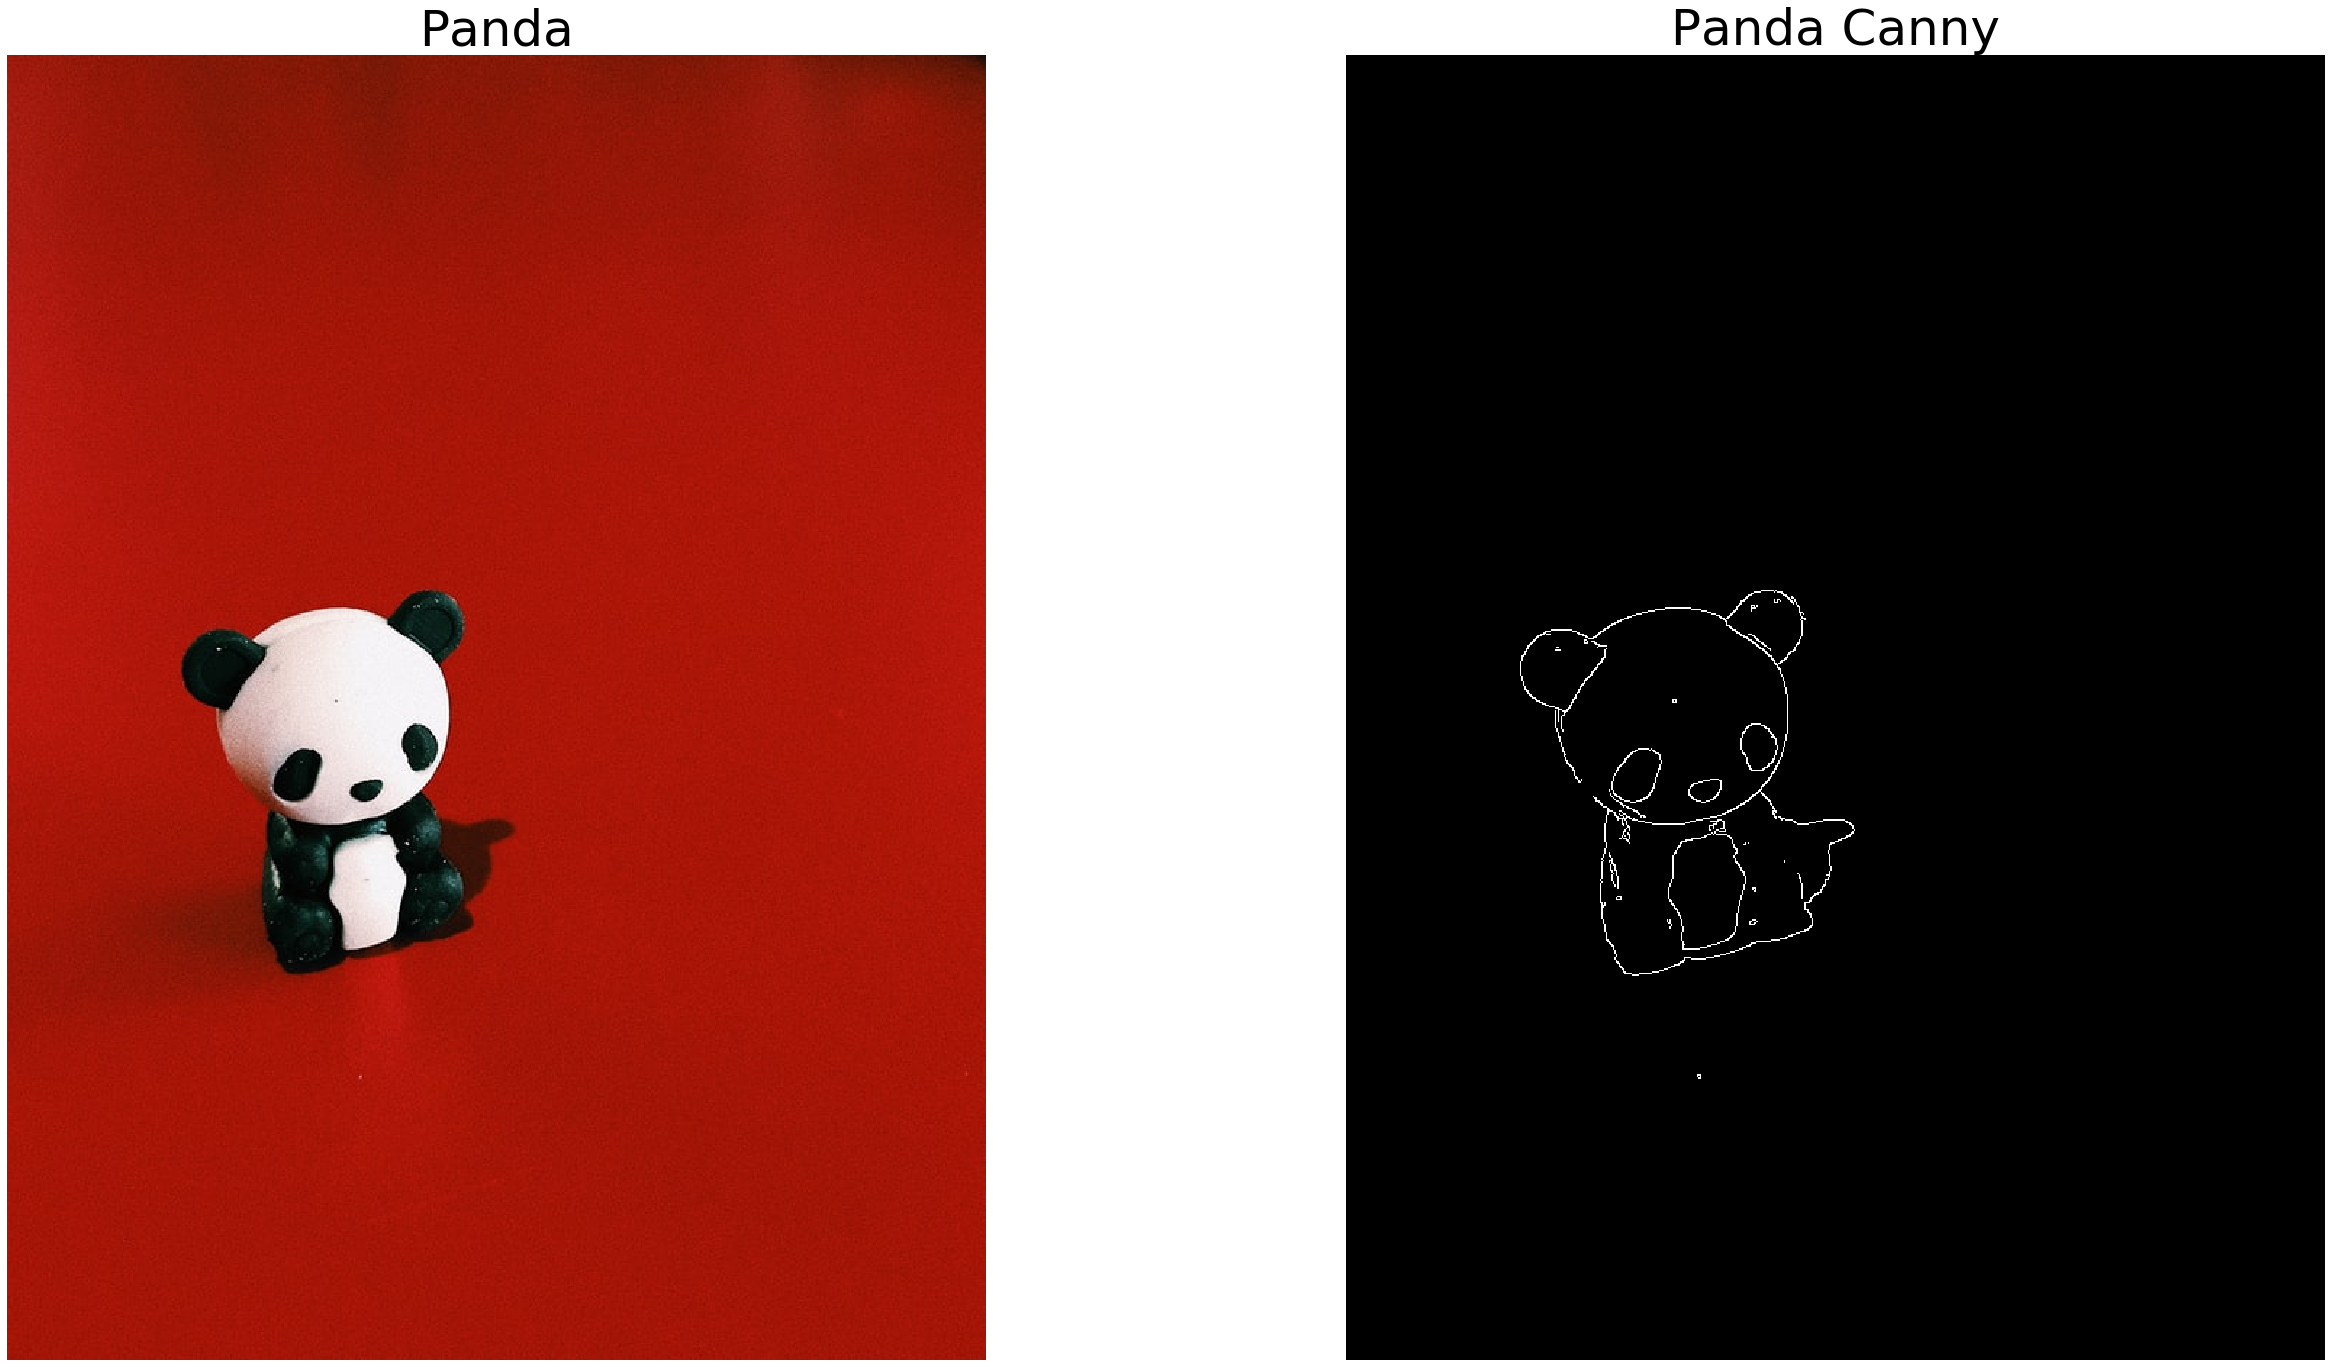

In [8]:
panda = cv2.imread('tut_panda.jpg')
panda = cv2.cvtColor(panda, cv2.COLOR_BGR2RGB)

panda_canny = cv2.Canny(panda, 100, 400)
plot_images([panda,panda_canny], ['Panda','Panda Canny'], subplot_shape=(1,3),fontsize=50, figsize=(68,24))

**sourse link:**<br>https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html<br>https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123<br>

#### 1. Noise Reduction

Cut the image to panda only and then blur it using Gaussian Kernel

In [9]:
panda2 = cv2.imread('tut_panda.jpg')
panda2 = cv2.cvtColor(panda2, cv2.COLOR_BGR2GRAY)

In [10]:
panda2.shape

(900, 675)

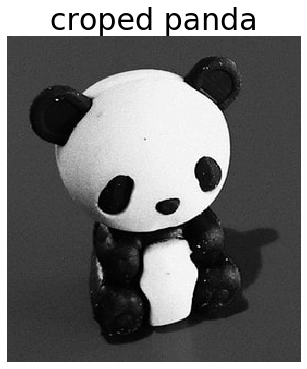

In [11]:
crop_img = panda2[350:650,100:370].copy()
plot_images([crop_img],['croped panda'],subplot_shape=(1,1),figsize=(18,6))

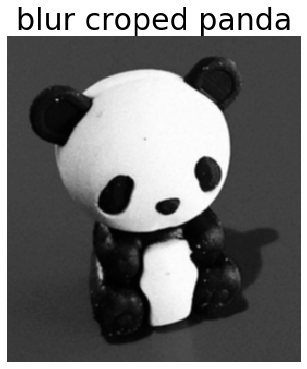

In [12]:
dst= cv2.GaussianBlur(crop_img,(3,3),0).astype("uint8")
plot_images([dst],['blur croped panda'],subplot_shape=(1,1),figsize=(18,6))

#### 2. Finding Magnitude and Orientation of Gradient 

Create gradient magnitude matrix (remember to normalize)<br>
Create a Theta matrix with the angels

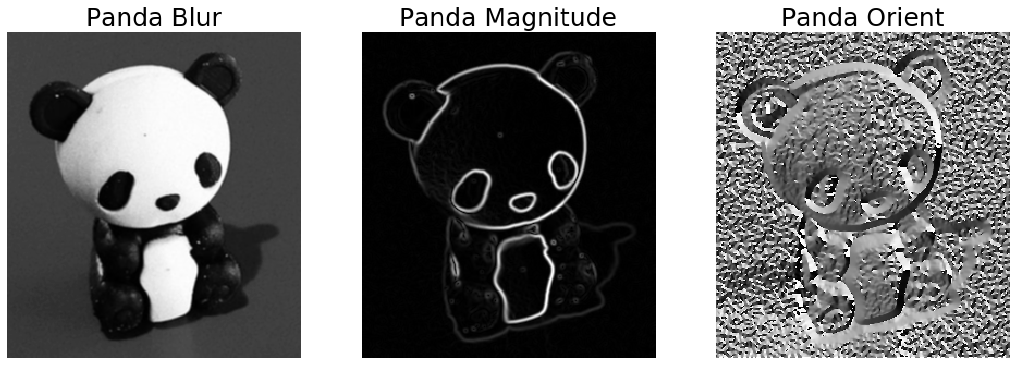

In [13]:
sobelx_panda,sobely_panda, mag_panda ,theta_panda = get_gradient(dst)

plot_images([dst,mag_panda,theta_panda],
            ['Panda Blur','Panda Magnitude','Panda Orient'],
            subplot_shape=(1,3),
            fontsize=25, 
            figsize=(18,6))

#### 3. Non-Maximum Suppression

https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/<br>https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123<br>https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/

In [14]:
def maximum(det, phase):
  gmax = np.zeros(det.shape)
  for i in np.arange(gmax.shape[0]):
    for j in np.arange(gmax.shape[1]):
      if phase[i][j] < 0:
        phase[i][j] += 360

      if ((j+1) < gmax.shape[1]) and ((j-1) >= 0) and ((i+1) < gmax.shape[0]) and ((i-1) >= 0):
        # 0 degrees
        if (phase[i][j] >= 337.5 or phase[i][j] < 22.5) or (phase[i][j] >= 157.5 and phase[i][j] < 202.5):
          if det[i][j] >= det[i][j + 1] and det[i][j] >= det[i][j - 1]:
            gmax[i][j] = det[i][j]
        # 45 degrees
        if (phase[i][j] >= 22.5 and phase[i][j] < 67.5) or (phase[i][j] >= 202.5 and phase[i][j] < 247.5):
          if det[i][j] >= det[i - 1][j + 1] and det[i][j] >= det[i + 1][j - 1]:
            gmax[i][j] = det[i][j]
        # 90 degrees
        if (phase[i][j] >= 67.5 and phase[i][j] < 112.5) or (phase[i][j] >= 247.5 and phase[i][j] < 292.5):
          if det[i][j] >= det[i - 1][j] and det[i][j] >= det[i + 1][j]:
            gmax[i][j] = det[i][j]
        # 135 degrees
        if (phase[i][j] >= 112.5 and phase[i][j] < 157.5) or (phase[i][j] >= 292.5 and phase[i][j] < 337.5):
          if det[i][j] >= det[i - 1][j - 1] and det[i][j] >= det[i + 1][j + 1]:
            gmax[i][j] = det[i][j]
  return gmax

panda_non_max = maximum(mag_panda, theta_panda)

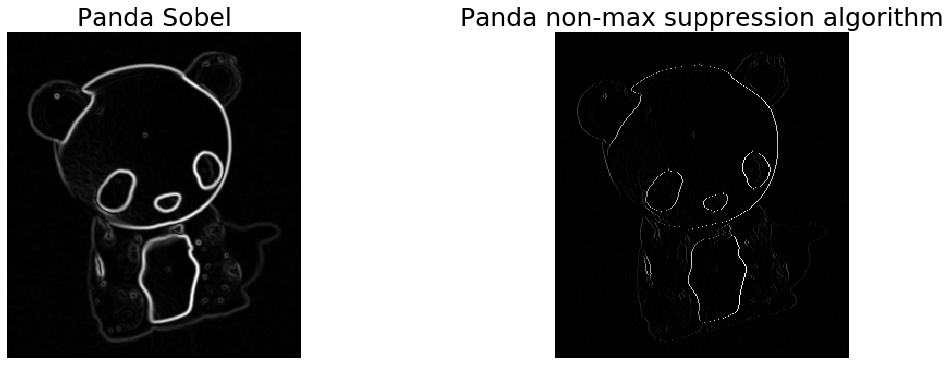

In [15]:
plot_images([mag_panda,panda_non_max],
            ['Panda Sobel','Panda non-max suppression algorithm'],
            subplot_shape=(1,2),
            fontsize=25, 
            figsize=(18,6))

#### 4.i. Thresholding

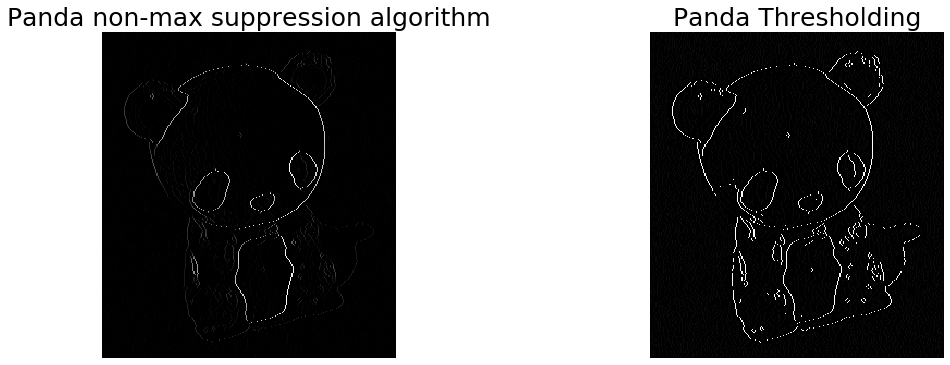

In [35]:
def threshold(img,lowThreshold=0.001, highThreshold=0.09):
    
        highThreshold = img.max() * highThreshold;
        lowThreshold = highThreshold * lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(10)
        strong = np.int32(255)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

panda_thresh = threshold(panda_non_max.copy())

plot_images([panda_non_max,panda_thresh],
            ['Panda non-max suppression algorithm','Panda Thresholding'],
            subplot_shape=(1,2),
            fontsize=25, 
            figsize=(18,6))


#### 4.2. Hysteresis Thresholding

In [36]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img
panda_hystr = hysteresis(panda_non_max.copy(),10,255)

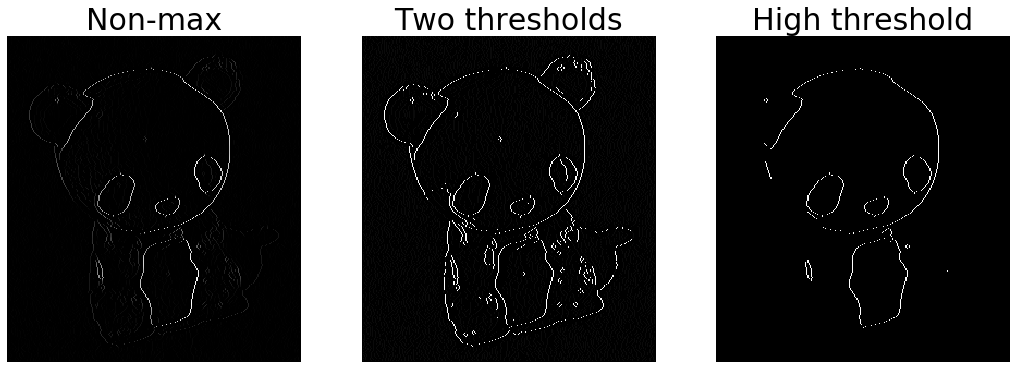

In [37]:
plot_images([panda_non_max, panda_thresh, panda_hystr > 75], 
            ['Non-max', 'Two thresholds', 'High threshold'], 
            subplot_shape=(1,3), 
            figsize=(18,6))

I was interested how this algorithm works  from the box, so now i have a little different result below. Different ways of implementation give different results. My way from scratch was not very good as i can see now))

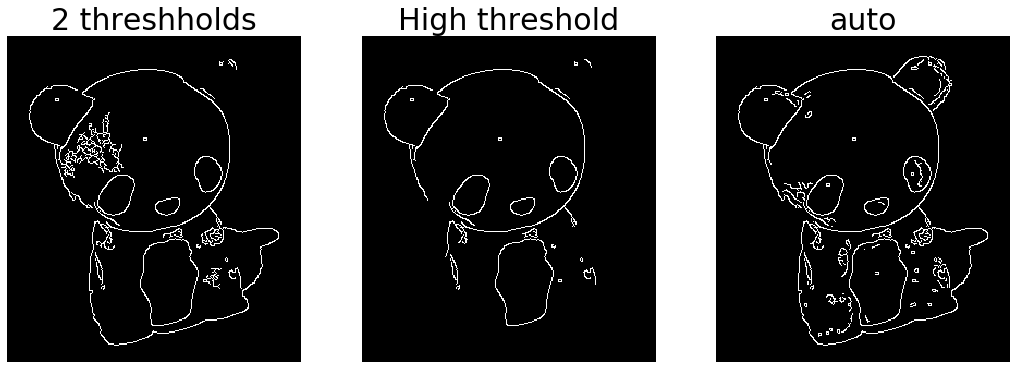

In [38]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged


gray = crop_img.copy()
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
# apply Canny edge detection using a wide threshold, tight
# threshold, and automatically determined threshold
two_thesh = cv2.Canny(blurred, 10, 255)
high = cv2.Canny(blurred, 75, 255)
auto = auto_canny(blurred)


plot_images([two_thesh, high, auto], 
            ['2 threshholds', 'High threshold', 'auto'], 
            subplot_shape=(1,3), 
            figsize=(18,6))